# Import libraries

In [21]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


#model selection
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Add,Dropout, Dense, Activation, ZeroPadding2D, \
BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
import PIL
import PIL.Image

import glob   
import shutil


In [26]:
directory_path = './Furniture_Data/lamps/Modern/11286modern-lighting.jpg'  
shutil.rmtree(directory_path)

# Read the dataset

In [27]:
# Global lists for storing data
images = []
labels = []
dimensions = []

# This function returns the class name according to the furniture type and style
def assign_label(furniture_type, style):
    return f"{furniture_type}_{style}"

# Function to read all images in a specific subdirectory based on type and style
def make_train_data(furniture_type, style):
    base_dir = os.path.join(os.curdir, "Furniture_Data", furniture_type, style)

    for img in tqdm(os.listdir(base_dir)):
        label = assign_label(furniture_type, style)
        path = os.path.join(base_dir, img)
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        if image is not None:
            images.append(image)
            labels.append(label)
            dimensions.append(image.shape)
        else:
            print(f"Failed to read image {path}")

# List of furniture categories and styles
furniture_categories = ['beds', 'chairs', 'dressers', 'lamps', 'sofas', 'tables']
styles = [
    'Asian', 'Beach', 'Contemporary', 'Craftsman', 'Eclectic', 'Farmhouse', 'Industrial',
    'Mediterranean', 'Midcentury', 'Modern', 'Rustic', 'Scandinavian', 'Southwestern',
    'Traditional', 'Transitional', 'Tropical', 'Victorian'
]

# Iterate over each category and style to process all images
for category in furniture_categories:
    for style in styles:
        make_train_data(category, style)


100%|██████████| 46/46 [00:00<00:00, 249.66it/s]


# EDA 

In [28]:
img_df = pd.DataFrame(dimensions, columns = ['Height', 'Width', 'Channels'])

print(img_df)

       Height  Width  Channels
0         350    350         3
1         350    350         3
2         350    350         3
3         350    350         3
4         350    350         3
...       ...    ...       ...
90078     350    350         3
90079     350    350         3
90080     350    350         3
90081     350    350         3
90082     350    350         3

[90083 rows x 3 columns]


In [39]:
# Count grayscale images (assuming grayscale images have 1 channel)
grayscale_count = (img_df['Channels'] == 1).sum()

# Count RGB images (assuming RGB images have 3 channels)
rgb_count = (img_df['Channels'] == 3).sum()

# Count RGB images (assuming RGB images have 3 channels)
rgba_count = (img_df['Channels'] == 4).sum()

print(f"Total grayscale images: {grayscale_count}")
print(f"Total RGB images: {rgb_count}")
print(f"Total RGBA images: {rgba_count}")



Total grayscale images: 0
Total RGB images: 90083
Total RGBA images: 0


In [30]:
import pandas as pd

# Assuming `labels` contains entries like 'beds_Asian', 'chairs_Modern', etc.
# Extract the furniture type from each label
furniture_types = [label.split('_')[0] for label in labels]

# Create a DataFrame with the furniture types
df = pd.DataFrame(furniture_types, columns=['Furniture Type'])

# Count the occurrences of each furniture type
type_counts = df['Furniture Type'].value_counts()

# Print the counts
print(type_counts)


Furniture Type
lamps       32401
chairs      22053
tables      17100
dressers     7871
beds         6578
sofas        4080
Name: count, dtype: int64


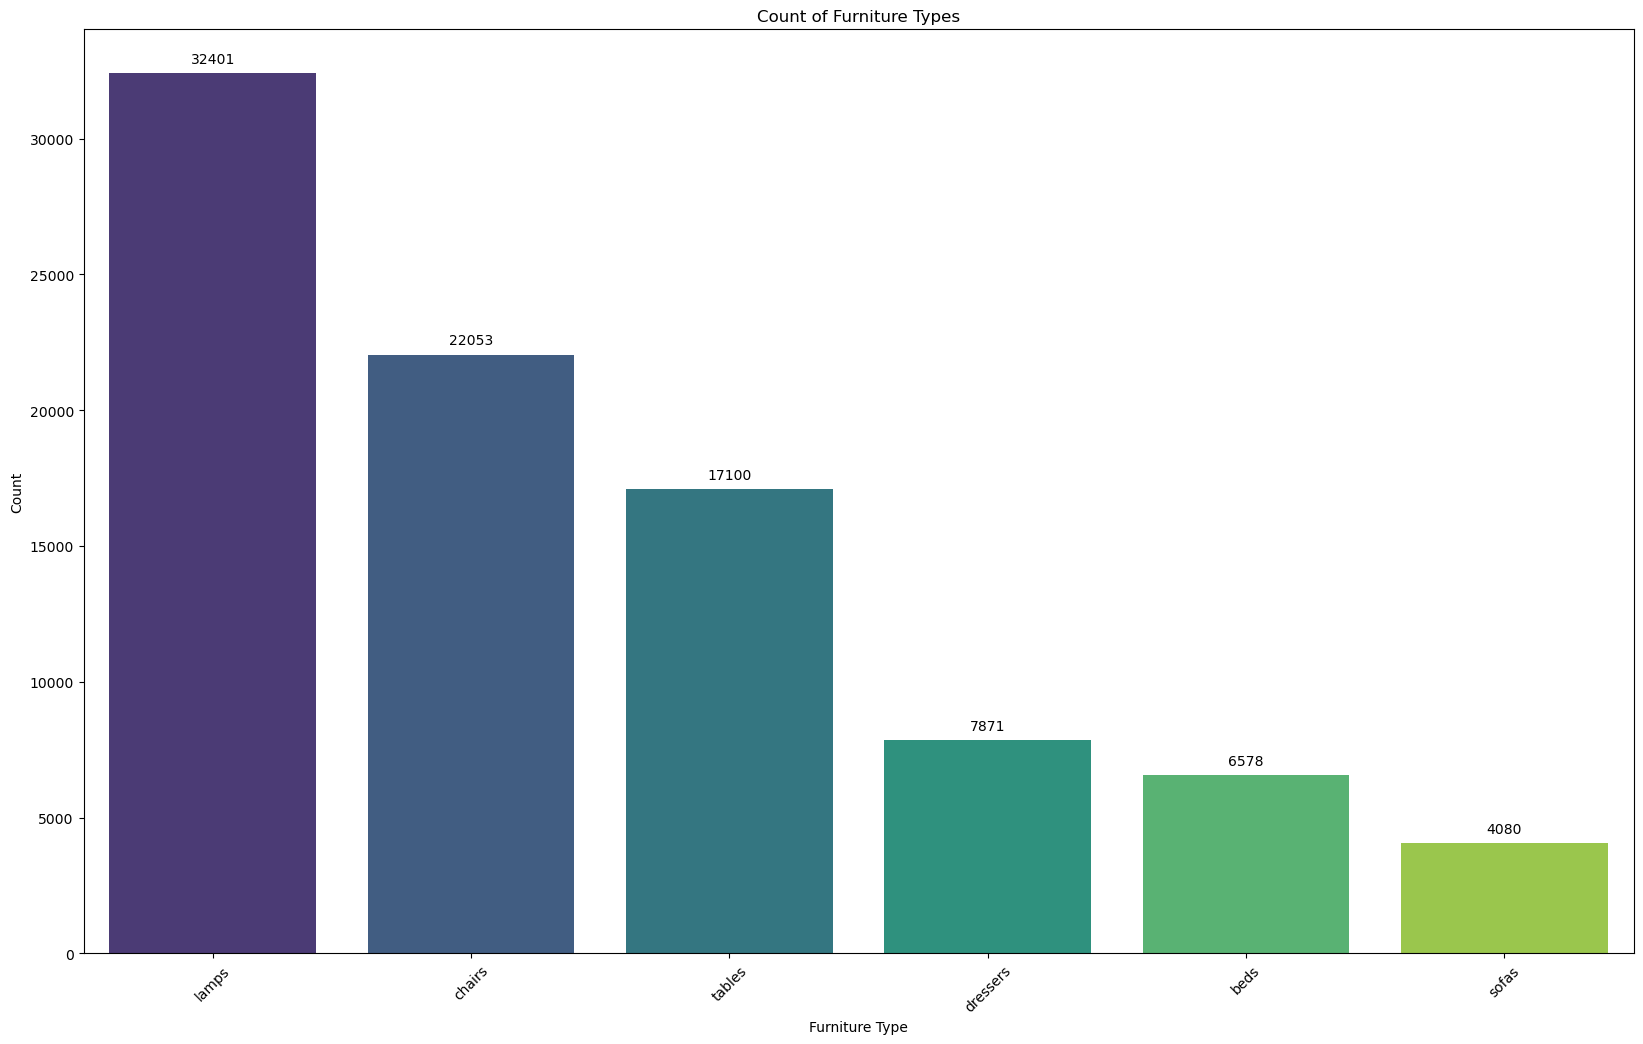

In [38]:
type_counts = df['Furniture Type'].value_counts().reset_index()
type_counts.columns = ['Furniture Type', 'Count']  

plt.figure(figsize=(20, 12))
ax = sns.barplot(x='Furniture Type', y='Count', data=type_counts, palette='viridis') 

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.title('Count of Furniture Types') 
plt.xlabel('Furniture Type') 
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.show()

In [32]:
df_filter = img_df.loc[(img_df['Width'] < 500) & (img_df['Height'] < 500)] 
print(df_filter)

       Height  Width  Channels
0         350    350         3
1         350    350         3
2         350    350         3
3         350    350         3
4         350    350         3
...       ...    ...       ...
90078     350    350         3
90079     350    350         3
90080     350    350         3
90081     350    350         3
90082     350    350         3

[90082 rows x 3 columns]


Text(0, 0.5, 'Height')

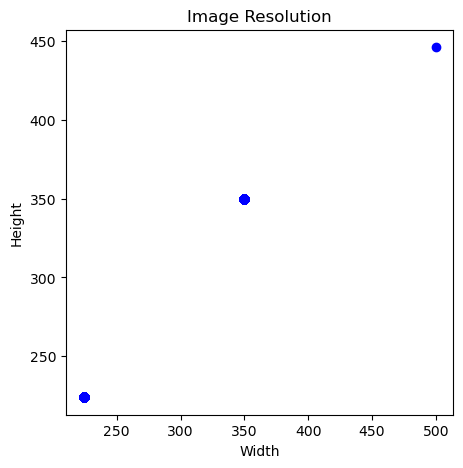

In [34]:
# Resolution sketching
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
points = ax.scatter(img_df.Width, img_df.Height, color='blue', picker=True)
ax.set_title("Image Resolution")
ax.set_xlabel("Width", size=10)
ax.set_ylabel("Height", size=10)

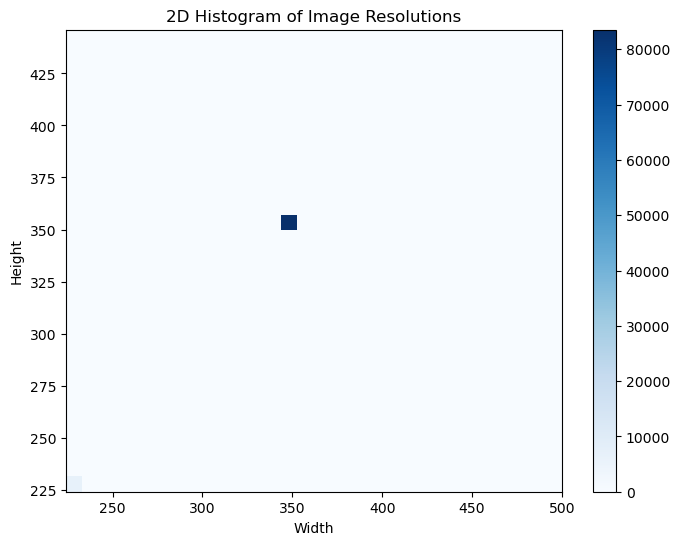

In [25]:
# Create a 2D histogram or heatmap of image widths and heights
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.hist2d(img_df.Width, img_df.Height, bins=30, cmap='Blues')
ax.set_title("2D Histogram of Image Resolutions")
ax.set_xlabel("Width")
ax.set_ylabel("Height")
plt.colorbar(h[3], ax=ax)
plt.show()


   Width  Height  Count
0    224     224   6537
1    350     350  83545
2    500     446      1


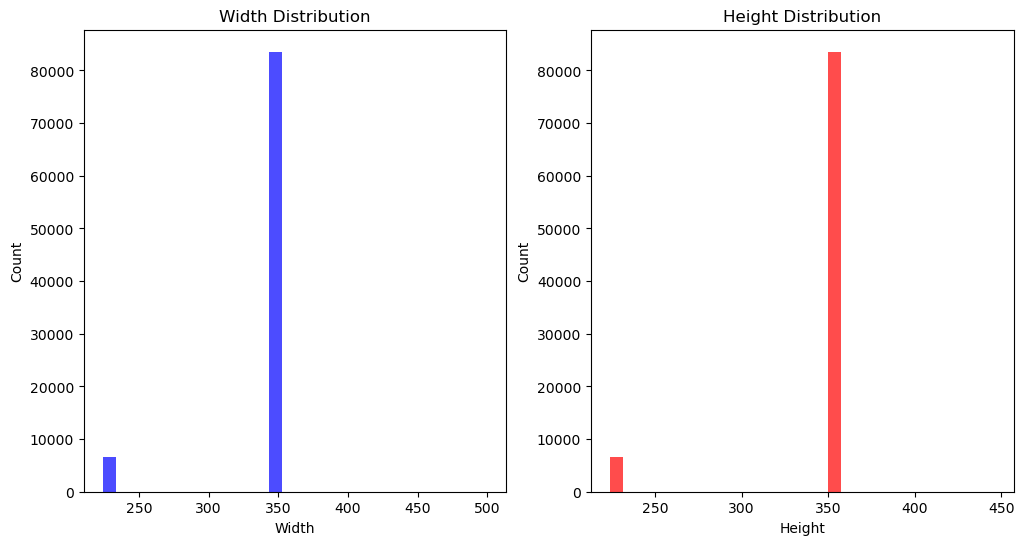

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(img_df.Width, bins=30, color='blue', alpha=0.7)
ax[0].set_title("Width Distribution")
ax[0].set_xlabel("Width")
ax[0].set_ylabel("Count")

ax[1].hist(img_df.Height, bins=30, color='red', alpha=0.7)
ax[1].set_title("Height Distribution")
ax[1].set_xlabel("Height")
ax[1].set_ylabel("Count")
# Check counts for specific resolutions

# Check counts for specific resolutions
resolution_counts = img_df.groupby(['Width', 'Height']).size().reset_index(name='Count')
print(resolution_counts)

plt.show()


## Display random images with their labels 

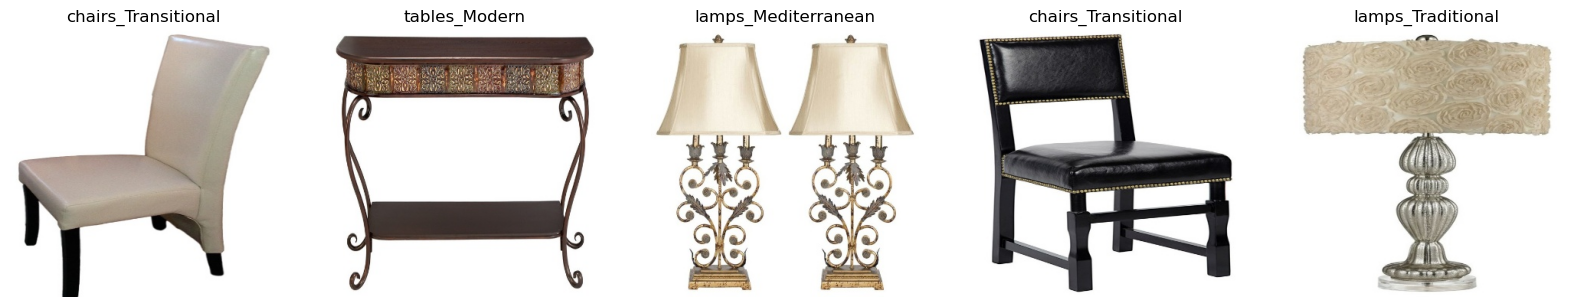

In [18]:
import random

# Function to display random images along with their labels
def display_random_images(images, labels, num_to_display=5):
    if len(images) < num_to_display:
        num_to_display = len(images)  # Adjust if the request exceeds available images
    
    plt.figure(figsize=(20, 10))  # Set the figure size for displaying images
    
    for i in range(num_to_display):
        # Generate a random index
        idx = random.randint(0, len(images) - 1)
        
        # Plot configuration
        plt.subplot(1, num_to_display, i + 1)  # Arguments are (rows, columns, index)
        plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  # Convert BGR to RGB and display
        plt.title(labels[idx])
        plt.axis('off')  # Hide the axis
    
    plt.show()

# Example usage of the function
display_random_images(images, labels, num_to_display=5)
